In [37]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
meta = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')

In [28]:
test = pd.read_csv('test_public.csv')

In [5]:
mapper = {'A':1,'B':2,'C':3}

In [29]:
train = train.replace({"CALL_TYPE":mapper,"DAY_TYPE":mapper})
test = test.replace({"CALL_TYPE":mapper,"DAY_TYPE":mapper})

In [ ]:
## run this cell only if u dont have train_time.csv

In [14]:
time = train['POLYLINE'].apply(lambda x: (len(eval(x))-1)*15)

In [22]:
time.to_csv('train_time.csv',index=False)

In [ ]:
## get train_time

In [114]:
time = pd.read_csv('train_time.csv')

In [ ]:
## sample linear regression

In [24]:
from sklearn.linear_model import LinearRegression

In [27]:
reg = LinearRegression().fit(train[["CALL_TYPE","TIMESTAMP","DAY_TYPE","MISSING_DATA"]], time)

In [34]:
trainPred = reg.predict(train[["CALL_TYPE","TIMESTAMP","DAY_TYPE","MISSING_DATA"]])
(np.mean((trainPred-time)**2))**0.5

684.6503561542685

In [35]:
test_pred = reg.predict(test[["CALL_TYPE","TIMESTAMP","DAY_TYPE","MISSING_DATA"]])

In [71]:
#####

In [38]:
model = nn.Sequential(
    nn.Linear(4, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [39]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [43]:
from sklearn.model_selection import train_test_split

In [115]:
X = train[["CALL_TYPE","TIMESTAMP","DAY_TYPE","MISSING_DATA"]].to_numpy().astype(float)
y = time.to_numpy()

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [117]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [118]:
save = {'w':None,'history':[],'mse':np.inf}

In [119]:
if os.path.exists('weight.pt'):
    save['w'] = torch.load('weight.pt')
if os.path.exists('history.txt'):
    with open('history.txt', 'r') as filehandle:
        for line in filehandle:
            save['history'].append(float(line[:-1]))
if os.path.exists('best_mse.txt'):
    with open('history.txt', 'r') as filehandle:
        for line in filehandle:
            save['mse']= float(line[:-1])

In [90]:
n_epochs = 100   # number of epochs to run
batch_size = 128  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

best_mse = save['mse']  # init to infinity
best_weights = save['w']
history = save['history']

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

model.load_state_dict(best_weights)

<All keys matched successfully>

In [91]:
save['mse'] = best_mse
save['history'] = history
save['w']=best_weights

In [ ]:
###save the progress so far

In [107]:
torch.save(save['w'], 'weight.pt')
with open('history.txt', 'w') as f:
    for line in history:
        f.write("%s\n" % line)
with open('best_mse.txt', 'w') as f:
    f.write("%s\n" % save['mse'])

MSE: 605450.75
RMSE: 778.11


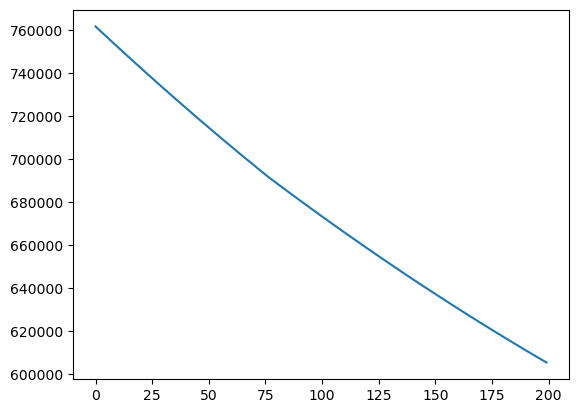

In [93]:
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()